## Prepare the data

1. To begin, download the Titanic data from [hbiostat.org](https://hbiostat.org/data/repo/titanic3.csv) as a CSV file (download links in the upper right) named `titanic3.csv` and save it to the `hello_ds/data` folder that we created in the previous section.

2. If we haven't already opened the file in VS Code, open the `hello_ds` folder and the Jupyter notebook (`hello.ipynb`), by going to **File > Open Folder**.

3. Within our Jupyter notebook, begin by importing the [pandas](https://pandas.pydata.org/) and [numpy(https://numpy.org/)] libraries, two common libraries used for manipulating data, and loading the Titanic data into a pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). To do so, copy the code below into the first cell of the notebook. For more guidance about working with Jupyter notebooks in VS Code, see the [Working with Jupyter Notebooks](https://code.visualstudio.com/docs/datascience/jupyter-notebooks) documentation.

In [20]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/titanic3.csv')

4. Now, run the cell using the Run cell icon or the `Shift+Enter` shortcut.
5. After the cell finishes running, we can view the data that was loaded using the Variables Explorer and Data Viewer. First select the **Variables** icon in the notebook's upper toolbar.
6. A **JUPYTER: VARIABLES** pane will open at the bottom of VS Code. It contains a list of the variables defined so far in our running kernel.
7. To view the data in the Pandas DataFrame previously loaded, select the Data Viewer icon to the left of the `data` variable.
8. Use the Data Viewer to view, sort, and filter the rows of data. After reviewing the data, it can then be helpful to graph some aspects of it to help visualize the relationships between the different variables.
9. Before the data can be graphed, we need to make sure that there aren't any issues with it. If we look at the Titanic csv file, one thing we'll notice is that a question mark ("?") was used to identify cells where data wasn't available.

While Pandas can read this value into a DataFrame, the result for a column like **age** is that its data type will be set to **object** instead of a numeric data type, which is problematic for graphing.

This problem can be corrected by replacing the question mark with a missing value that pandas is able to understand. Add the following code to the next cell in wer notebook to replace the question marks in the **age** and **fare** columns with the [numpy NaN](https://docs.scipy.org/doc/numpy/reference/constants.html?highlight=nan#numpy.nan) value. Notice that we also need to update the column's data type after replacing the values.

In [21]:
data.replace('?', np.nan, inplace=True)
data = data.astype({"age":np.float64,"fare":np.float64,"body":np.float64})

10. Now that the data is in good shape, we can use [seaborn](https://seaborn.pydata.org/) and [matplotlib](https://matplotlib.org/) to view how certain columns of the dataset relate to survivability. Add the following code to the next cell in our notebook and run it to see the generated plots.

<Axes: xlabel='survived', ylabel='fare'>

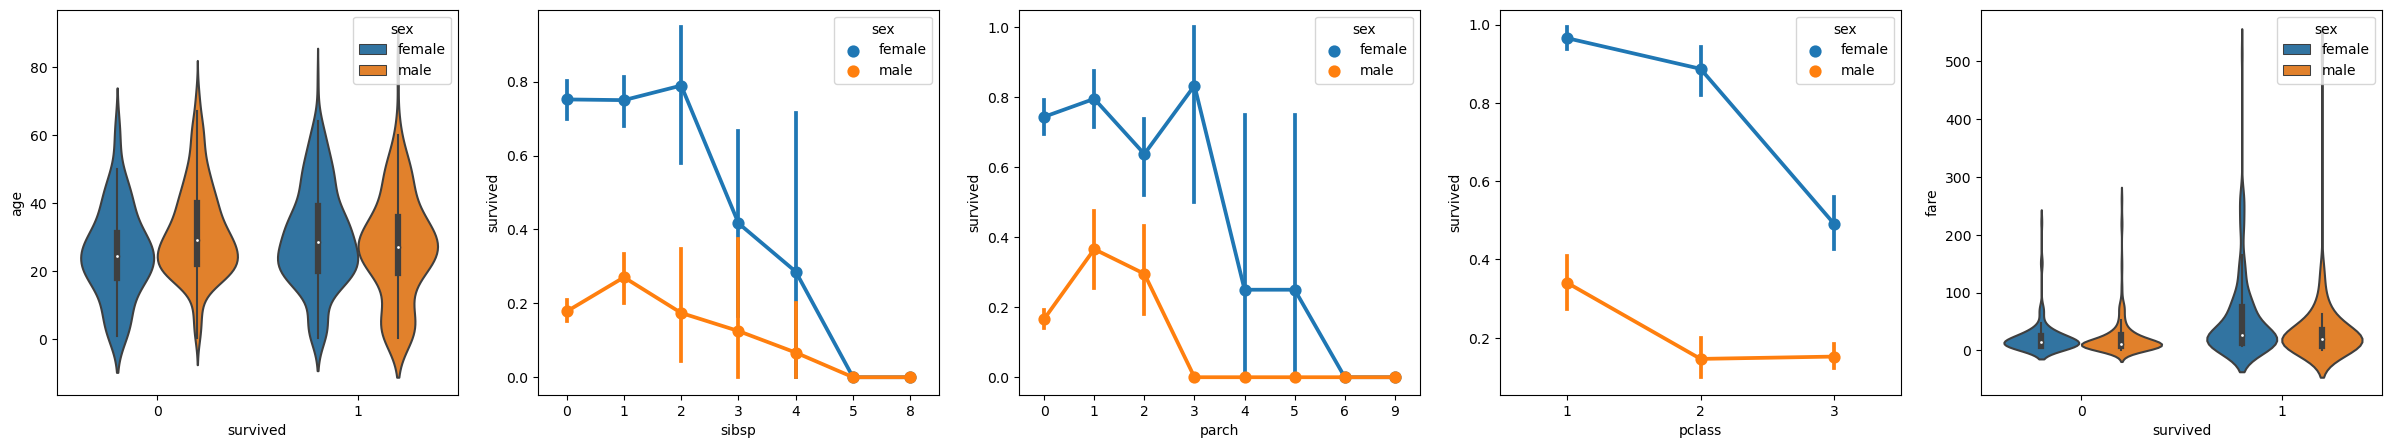

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=5, figsize=(30,5))
sns.violinplot(x="survived",y="age", hue="sex", data=data, ax=axs[0])
sns.pointplot(x="sibsp",y="survived", hue="sex", data=data, ax=axs[1])
sns.pointplot(x="parch",y="survived", hue="sex", data=data, ax=axs[2])
sns.pointplot(x="pclass",y="survived", hue="sex", data=data, ax=axs[3])
sns.violinplot(x="survived",y="fare", hue="sex", data=data, ax=axs[4])

11. These graphs are helpful in seeing some of the relationships between survival and the input variables of the data, but it's also possible to use **pandas** to calculate correlations. To do so, all the variables used need to be numeric for the correlation calculation and currently gender is stored as a string. To convert those string values to integers, add and run the following code.

In [23]:
data.replace({"male":1, "female":0}, inplace=True)

12. Now, we can analyze the correlation between all the input variables to identify the features that would be the best inputs to a machine learning model. The closer a value is to 1, the higher the correlation between the value and the result. Use the following code to correlate the relationship between all variables and survival.

In [24]:
data.corr(numeric_only=True).abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN


13. Looking at the correlation results, we'll notice that some variables like gender have a fairly high correlation to survival, while others like relatives (sibsp = siblings or spouse, parch = parents or children) seem to have little correlation.

Let's hypothesize that **sibsp** and **parch** are related in how they affect survivability, and group them into a new column called "relatives" to see whether the combination of them has a higher correlation to survivability. To do this, we will check if for a given passenger, the number of **sibsp** and **parch** is greater than 0 and, if so, we can then say that they had a relative on board.

Use the following code to create a new variable and column in the dataset called `relatives` and check the correlation again.

In [25]:
data['relatives'] = data.apply(lambda row: int((row['sibsp'] + row['parch'])>0),axis=1)
data.corr(numeric_only=True).abs()[['survived']]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN
relatives,0.201719


14. we'll notice that in fact when looked at from the standpoint of whether a person had relatives, versus how many relatives, there is a higher correlation with survival. With this information in hand, we can now drop from the dataset the low value sibsp and parch columns, as well as any rows that had NaN values, to end up with a dataset that can be used for training a model.

In [26]:
data = data[['sex','pclass','age','relatives','fare','survived']].dropna()

**Note**: Although age had a low direct correlation, it was kept because it seems reasonable that it might still have correlation in conjunction with other inputs.

## Train and evaluate a model

With the dataset ready, we can now begin creating a model. For this section, we'll use the [scikit-learn](https://scikit-learn.org/stable/) library (as it offers some useful helper functions) to do pre-processing of the dataset, train a classification model to determine survivability on the Titanic, and then use that model with test data to determine its accuracy.

1. A common first step to training a model is to divide up the dataset into training and validation data. This allows us to use a portion of the data to train the model and a portion of the data to test the model. If we used all our data to train the model, we wouldn't have a way to estimate how well it would actually perform against data the model hasn't yet seen. A benefit of the scikit-learn library is that it provides a method specifically for splitting a dataset into training and test data.

Add and run a cell with the following code to the notebook to split up the data.

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data[['sex','pclass','age','relatives','fare']], data.survived, test_size=0.2, random_state=0)

2. Next, we'll normalize the inputs such that all features are treated equally. For example, within the dataset the values for age range from ~0-100, while gender is only a 1 or 0. By normalizing all the variables, we can ensure that the ranges of values are all the same. Use the following code in a new code cell to scale the input values.

In [28]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

3. There are many different machine learning algorithms that you could choose from to model the data. The scikit-learn library also provides support for many of [them](https://scikit-learn.org/stable/user_guide.html) and a [chart](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to help select the one that's right for our scenario. For now, use the [Naïve Bayes algorithm](https://scikit-learn.org/stable/modules/naive_bayes.html), a common algorithm for classification problems. Add a cell with the following code to create and train the algorithm.

In [29]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(x_train, y_train)

GaussianNB()

4. With a trained model, we can now try it against the test data set that was held back from training. Add and run the following code to predict the outcome of the test data and calculate the accuracy of the model.

In [30]:
from sklearn import metrics

predict_test = model.predict(x_test)
print(metrics.accuracy_score(y_test,predict_test))

0.7607655502392344


## (Optional) Use a neural network

A neural network is a model that uses weights and activation functions, modeling aspects of human neurons, to determine an outcome based on provided inputs. Unlike the machine learning algorithm you looked at previously, neural networks are a form of deep learning wherein you don't need to know an ideal algorithm for your problem set ahead of time. It can be used for many different scenarios and classification is one of them. For this section, you'll use the [Keras](https://keras.io/) library with [TensorFlow](https://www.tensorflow.org/) to construct the neural network, and explore how it handles the Titanic dataset.

1. The first step is to import the required libraries and to create the model. In this case, you'll use a [Sequential](https://keras.io/getting-started/sequential-model-guide/) neural network, which is a layered neural network wherein there are multiple layers that feed into each other in sequence.

In [31]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

2023-07-13 20:10:39.463401: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2. After defining the model, the next step is to add the layers of the neural network. For now, let's keep things simple and just use three layers. Add the following code to create the layers of the neural network.

In [33]:
model.add(Dense(5, kernel_initializer='uniform',activation='relu',input_dim = 5))
model.add(Dense(5, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))

* The first layer will be set to have a dimension of 5, since you have five inputs: sex, pclass, age, relatives, and fare.
* The last layer must output 1, since you want a 1-dimensional output indicating whether a passenger would survive.
* The middle layer was kept at 5 for simplicity, although that value could have been different.

The rectified linear unit [(relu)](https://uk.wikipedia.org/wiki/ReLU) activation function is used as a good general activation function for the first two layers, while the [sigmoid](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%B3%D0%BC%D0%BE%D0%B8%D0%B4%D0%B0) activation function is required for the final layer as the output you want (of whether a passenger survives or not) needs to be scaled in the range of 0-1 (the probability of a passenger surviving).

You can also look at the summary of the model you built with this line of code:

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


3. Once the model is created, it needs to be compiled. As part of this, you need to define what type of optimizer will be used, how loss will be calculated, and what metric should be optimized for. Add the following code to build and train the model. You'll notice that after training, the accuracy is ~61%.

  **Note:** This step may take anywhere from a few seconds to a few minutes to run depending on your machine.

In [35]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
27/27 [==============================] - 2s 8ms/step - loss: 0.6921 - accuracy: 0.5849
Epoch 2/50
27/27 [==============================] - 0s 8ms/step - loss: 0.6890 - accuracy: 0.5861
Epoch 3/50
27/27 [==============================] - 0s 7ms/step - loss: 0.6816 - accuracy: 0.5861
Epoch 4/50
27/27 [==============================] - 0s 12ms/step - loss: 0.6679 - accuracy: 0.5861
Epoch 5/50
27/27 [==============================] - 0s 9ms/step - loss: 0.6472 - accuracy: 0.5861
Epoch 6/50
27/27 [==============================] - 0s 10ms/step - loss: 0.6221 - accuracy: 0.5861
Epoch 7/50
27/27 [==============================] - 0s 10ms/step - loss: 0.5997 - accuracy: 0.5861
Epoch 8/50
27/27 [==============================] - 0s 10ms/step - loss: 0.5847 - accuracy: 0.5861
Epoch 9/50
27/27 [==============================] - 0s 13ms/step - loss: 0.5755 - accuracy: 0.5861
Epoch 10/50
27/27 [==============================] - 0s 8ms/step - loss: 0.5689 - accuracy: 0.5861
Epoch 11/50
27

4. Now that the model is built and trained, we can see how it works against the test data.

In [37]:
y_pred = np.rint(model.predict(x_test).flatten())
print(metrics.accuracy_score(y_test, y_pred))

7/7 [==============================] - 0s 6ms/step


0.8086124401913876


Similar to the training, you'll notice that you now have 80% accuracy in predicting survival of passengers. Using this simple neural network, the result is better than the 76% accuracy from the Naive Bayes Classifier tried previously.

## Next steps

Now that you're familiar with the basics of performing machine learning within Visual Studio Code, here are some other Microsoft resources and tutorials to check out.

* [Data Science profile template](https://code.visualstudio.com/docs/editor/profiles#_data-science-profile-template) - Create a new profile with a curated set of extensions, settings, and snippets.
* Learn more about working with [Jupyter Notebooks in Visual Studio Code](https://youtu.be/FSdIoJdSnig) (video).
* [**Get started with Azure Machine Learning for VS Code**](https://learn.microsoft.com/azure/machine-learning/how-to-setup-vs-code) to deploy and optimize your model using the power of Azure.
* Find more data to explore on [**Azure Open Data Sets**](https://azure.microsoft.com/services/open-datasets/).